<a href="https://colab.research.google.com/github/annchirackal/Tensorflow-Developer-Certification/blob/TF_Transfer_Learning/12_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####What is transfer learning?<br>

we can leverage an existing nueral network architecture proven to work on similar problems which is already learned patterns from dataset  similar  to our own.



Download the data:
we are going to use only 10 percent data, this would help us to understand the powe of transfer learning.

In [28]:
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import datetime

import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
## Global variables
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS=5

In [13]:
 !wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [14]:
# unzip the loaded file
zip_ref=zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [15]:
  #lets inspect the directory
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):

    print(f"{len(filenames)} files and  {len(dirnames)} in directory {dirpath}")


0 files and  2 in directory 10_food_classes_10_percent
0 files and  10 in directory 10_food_classes_10_percent/test
250 files and  0 in directory 10_food_classes_10_percent/test/grilled_salmon
250 files and  0 in directory 10_food_classes_10_percent/test/chicken_curry
250 files and  0 in directory 10_food_classes_10_percent/test/pizza
250 files and  0 in directory 10_food_classes_10_percent/test/ramen
250 files and  0 in directory 10_food_classes_10_percent/test/sushi
250 files and  0 in directory 10_food_classes_10_percent/test/chicken_wings
250 files and  0 in directory 10_food_classes_10_percent/test/fried_rice
250 files and  0 in directory 10_food_classes_10_percent/test/hamburger
250 files and  0 in directory 10_food_classes_10_percent/test/ice_cream
250 files and  0 in directory 10_food_classes_10_percent/test/steak
0 files and  10 in directory 10_food_classes_10_percent/train
75 files and  0 in directory 10_food_classes_10_percent/train/grilled_salmon
75 files and  0 in director

We have 75 images of each class for traning and 250 from each class for validation

In [16]:
 #### set the path variables

train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

train_data_gen=ImageDataGenerator(rescale=1./255,)
test_data_gen=ImageDataGenerator(rescale=1./255,)
print("Traning Images:")
train_data=train_data_gen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")
print("Testing Images:")
test_data=train_data_gen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Traning Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


Callbacks are extra functionality you can add to your model to be performed during or after training.Some of the most popular call backs are
- Model check point with the ModelCheckpoint callbacks.
- Tracking experiment with tensor board callbacks.
- Stopping a model from traning with EarlyStopping callbacks.

In [24]:
#create a tensorboard callbacks

def create_tensorboard_callback(dirname,experiment_name):
  log_dir=dirname+"/"+experiment_name+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,)
  print(f"Saving TensorBorad log files to {log_dir} ")
  return tensorboard_callback


Creating Models using Tensorflow hub<br>

In previous notebooks we have created custom models from scratch. Here we are creating a model by using layers from pretrained models availble in tensor hub.


In [18]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [19]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


In [20]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [26]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dirname="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log

Saving TensorBorad log files to tensorflow_hub/resnet50V220240123-165204 
Epoch 1/5
24/24 [==============================] - 23s 611ms/step - loss: 1.9632 - accuracy: 0.3720 - val_loss: 1.2022 - val_accuracy: 0.6120
Epoch 2/5
24/24 [==============================] - 14s 577ms/step - loss: 0.8875 - accuracy: 0.7507 - val_loss: 0.8367 - val_accuracy: 0.7428
Epoch 3/5
24/24 [==============================] - 13s 548ms/step - loss: 0.6019 - accuracy: 0.8347 - val_loss: 0.7532 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 12s 522ms/step - loss: 0.4705 - accuracy: 0.8667 - val_loss: 0.7046 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 11s 477ms/step - loss: 0.3697 - accuracy: 0.9133 - val_loss: 0.6784 - val_accuracy: 0.7796


Eventhouogh we used olnly 10% of the training data, we can see that the model performence increased compared to last one.

In [29]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

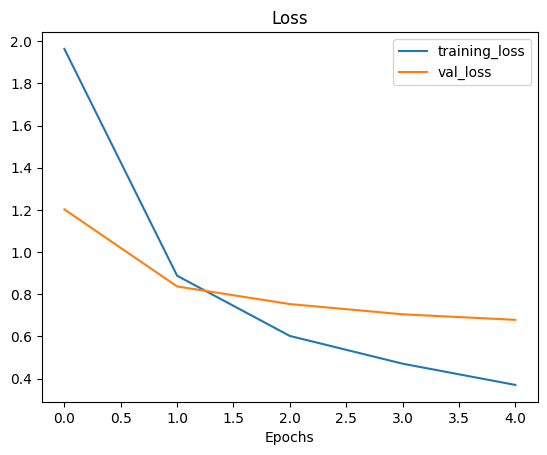

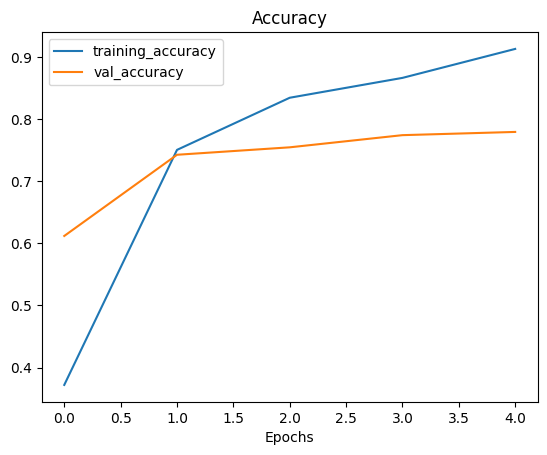

In [30]:
plot_loss_curves(resnet_history)

In [36]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=create_tensorboard_callback(dirname="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0"))

Saving TensorBorad log files to tensorflow_hub/efficientnetB020240123-165710 
Epoch 1/5
24/24 [==============================] - 26s 602ms/step - loss: 1.8425 - accuracy: 0.4587 - val_loss: 1.2642 - val_accuracy: 0.7580
Epoch 2/5
24/24 [==============================] - 10s 437ms/step - loss: 1.0448 - accuracy: 0.7880 - val_loss: 0.8577 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 10s 412ms/step - loss: 0.7553 - accuracy: 0.8293 - val_loss: 0.6873 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 10s 406ms/step - loss: 0.6038 - accuracy: 0.8640 - val_loss: 0.6059 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 11s 477ms/step - loss: 0.5138 - accuracy: 0.8907 - val_loss: 0.5525 - val_accuracy: 0.8608
